In [4]:
!pip install statsmodels

In [5]:
import pandas as pd

# Step 1: Load the Data

In [6]:
df = pd.read_csv('D:/git/sales-forecasting-ml/data/train.csv')



# Step 2: Exploratory Data Analysis (EDA)

In [7]:
df.head()
df.describe()
df.isnull().sum()
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

In [24]:
df['Order Date']

0       08/11/2017
1       08/11/2017
2       12/06/2017
3       11/10/2016
4       11/10/2016
           ...    
9795    21/05/2017
9796    12/01/2016
9797    12/01/2016
9798    12/01/2016
9799    12/01/2016
Name: Order Date, Length: 9800, dtype: object

### Describution of the key Columns

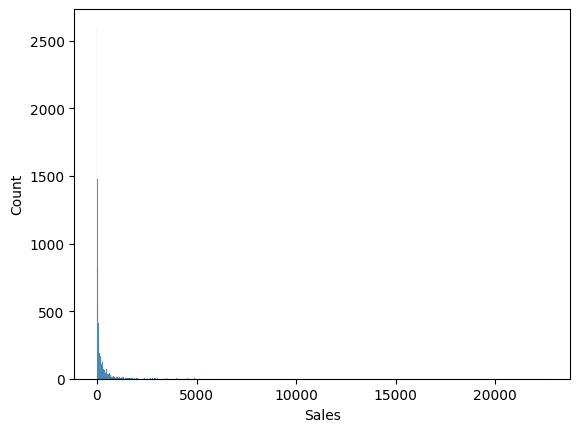

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['Sales'])
plt.show()

# Monthly Sales of all Products over Time

C:\Users\HP\AppData\Local\Temp\ipykernel_13172\4004125652.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.resample('M')['Sales'].sum()


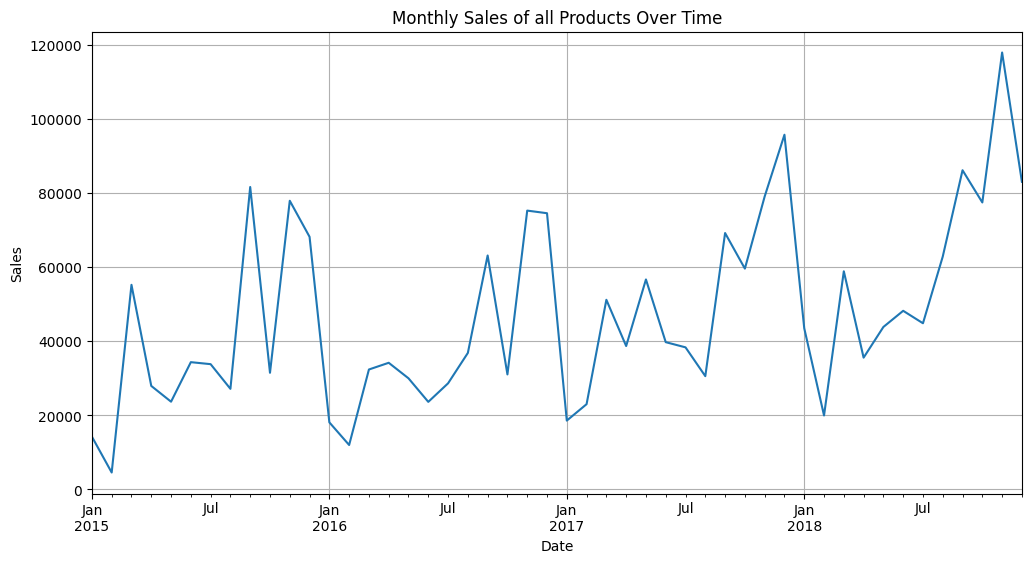

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Order Date' is a column (reset index if needed)
if 'Order Date' not in df.columns:
    df.reset_index(inplace=True)

# Convert 'Order Date' to datetime if not already
if not pd.api.types.is_datetime64_any_dtype(df['Order Date']):
    df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y', errors='coerce')

# Remove rows with invalid dates (NaT)
df.dropna(subset=['Order Date'], inplace=True)

# Set 'Order Date' as index
df.set_index('Order Date', inplace=True)

# Convert 'Sales' to numeric (if it's not already)
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

# Drop rows where 'Sales' is NaN
df.dropna(subset=['Sales'], inplace=True)

# Resample by month and calculate total sales
monthly_sales = df.resample('M')['Sales'].sum()

# Plot
plt.figure(figsize=(12, 6))
monthly_sales.plot()
plt.title('Monthly Sales of all Products Over Time')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [50]:
df['Product ID'].nunique()

Product ID
FUR-BO-10000112     825.174
FUR-BO-10000330    1064.624
FUR-BO-10000362    2154.348
FUR-BO-10000468     723.842
FUR-BO-10000711     851.760
                     ...   
TEC-PH-10004912     351.680
TEC-PH-10004922    1085.238
TEC-PH-10004924      56.164
TEC-PH-10004959     341.666
TEC-PH-10004977    5291.730
Name: Sales, Length: 1861, dtype: float64

In [56]:
df.groupby('Product ID')['Sales'].sum().sort_values(ascending=False).head(5)

Product ID
TEC-CO-10004722    61599.824
OFF-BI-10003527    27453.384
TEC-MA-10002412    22638.480
FUR-CH-10002024    21870.576
OFF-BI-10001359    19823.479
Name: Sales, dtype: float64

## Show the Sale of top 20 product

<Axes: title={'center': 'Top 20 Products by Sales'}, xlabel='Product ID'>

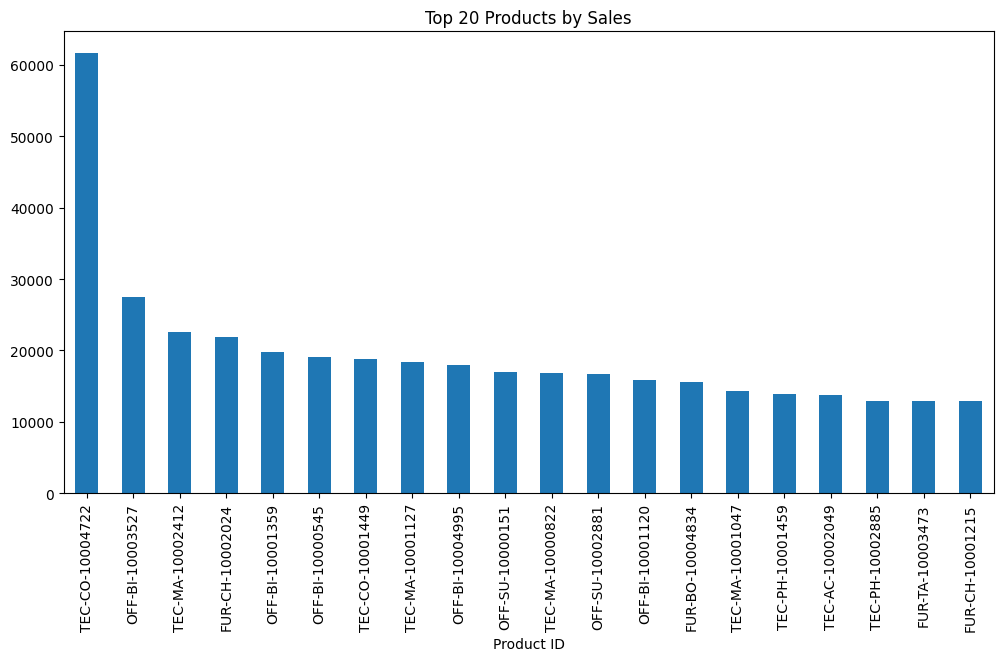

In [44]:
top_products = df.groupby('Product ID')['Sales'].sum().sort_values(ascending=False).head(20)
top_products.plot(kind='bar', figsize=(12,6), title='Top 20 Products by Sales')

# Seasonal Monthly Sales Trends By Year

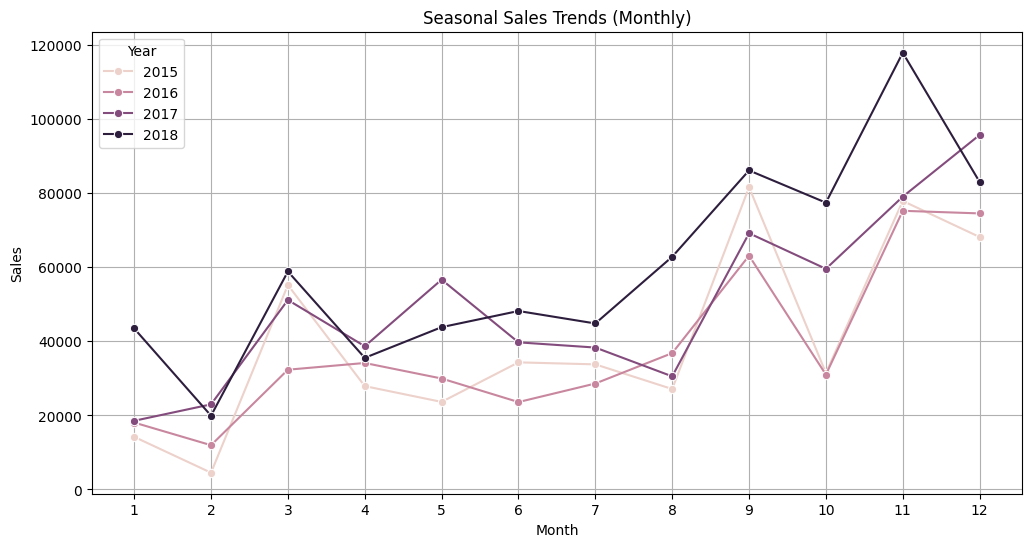

In [15]:
# Ensure 'Order Date' is a column (reset index if necessary)
if df.index.name == 'Order Date':
    df.reset_index(inplace=True)

# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

# Extract Year and Month
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month

# Group by Year and Month
monthly_sales = df.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Plot seasonal trends
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='Month', y='Sales', hue='Year', marker='o')
plt.title('Seasonal Sales Trends (Monthly)')
plt.xticks(range(1,13))
plt.grid(True)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()


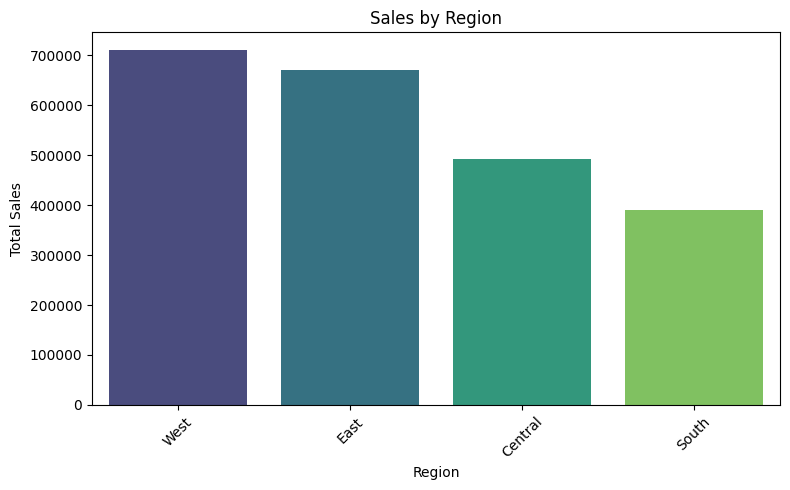

In [16]:
df['Region'].unique()
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=region_sales.index, y=region_sales.values, hue=region_sales.index, palette='viridis', legend=False)
plt.title('Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Total Sales for State

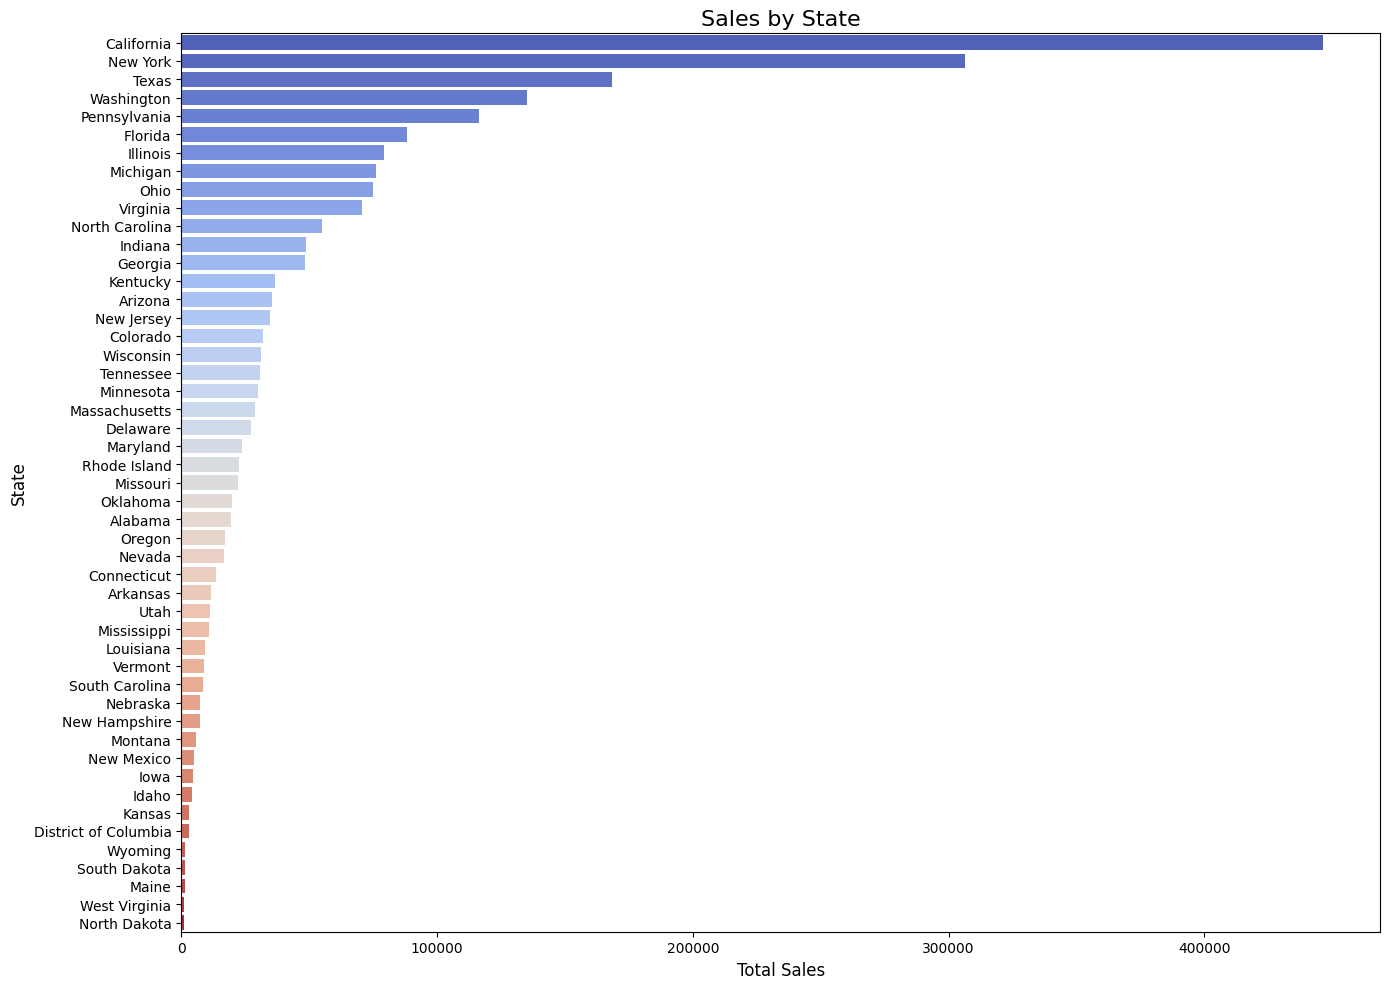

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by State
state_sales = df.groupby('State')['Sales'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 10))
sns.barplot(
    x=state_sales.values,
    y=state_sales.index,
    hue=state_sales.index,         # proper hue
    palette='coolwarm',
    dodge=False,                   # make sure bars aren't offset
    legend=False                   # we don't need the legend for states
)

plt.title('Sales by State', fontsize=16)
plt.xlabel('Total Sales', fontsize=12)
plt.ylabel('State', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


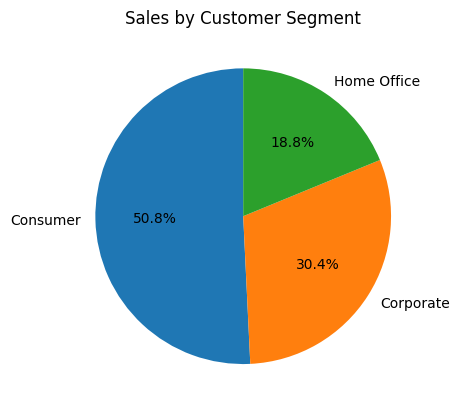

In [46]:
segment_sales = df.groupby('Segment')['Sales'].sum()
segment_sales.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Sales by Customer Segment')
plt.ylabel('')
plt.show()

# Step-by-Step: Sales Forecasting with ARIMA

# That ADF (Augmented Dickey-Fuller) test, if Time Series is Stationary

In [19]:
from statsmodels.tsa.stattools import adfuller

# Ensure you have a 1D Series
if isinstance(monthly_sales, pd.DataFrame):
    monthly_sales_series = monthly_sales['Sales']  # or change to correct column name
else:
    monthly_sales_series = monthly_sales

# Run ADF test
result = adfuller(monthly_sales_series.dropna())

# Display full results
print("===== Augmented Dickey-Fuller Test Results =====")
print(f"ADF Statistic       : {result[0]}")
print(f"p-value             : {result[1]}")
print(f"# of Lags Used      : {result[2]}")
print(f"# of Observations   : {result[3]}")
print("Critical Values     :")
for key, value in result[4].items():
    print(f"   {key} : {value:.3f}")

# Optional interpretation
if result[1] < 0.05:
    print("\n✅ The time series is **stationary** (p < 0.05).")
else:
    print("\n❌ The time series is **non-stationary** (p ≥ 0.05).")


===== Augmented Dickey-Fuller Test Results =====
ADF Statistic       : -4.416136761430769
p-value             : 0.00027791039276670623
# of Lags Used      : 0
# of Observations   : 47
Critical Values     :
   1% : -3.578
   5% : -2.925
   10% : -2.601

✅ The time series is **stationary** (p < 0.05).


# ARIMA Modeling

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -549.516
Date:                Mon, 21 Apr 2025   AIC                           1107.033
Time:                        12:07:49   BIC                           1114.518
Sample:                             0   HQIC                          1109.861
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.712e+04   6372.221      7.394      0.000    3.46e+04    5.96e+04
ar.L1          0.6655      0.280      2.373      0.018       0.116       1.215
ma.L1         -0.3053      0.353     -0.865      0.3

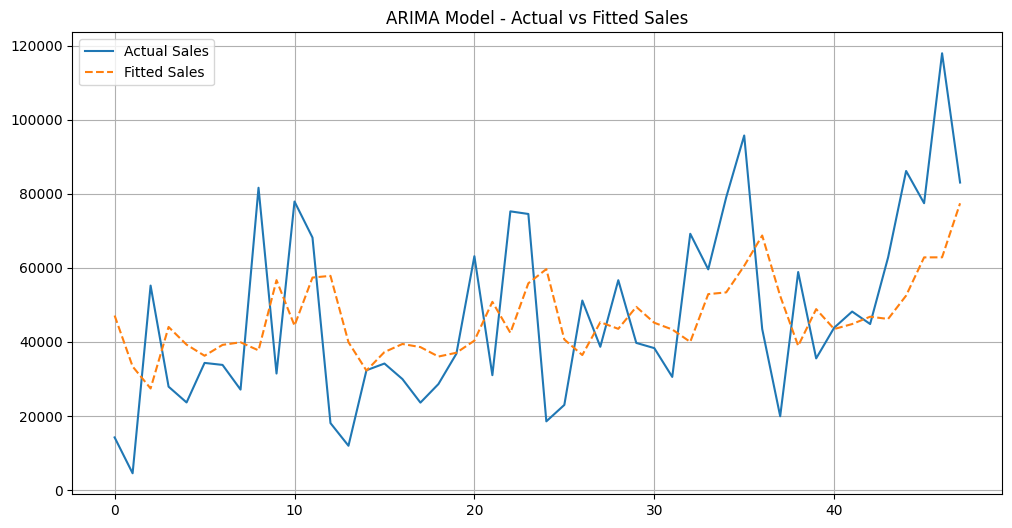

In [21]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Make sure you're using only the 'Sales' column
sales_series = monthly_sales['Sales'] if isinstance(monthly_sales, pd.DataFrame) else monthly_sales

# Fit ARIMA model with order (1, 0, 1)
model = ARIMA(sales_series, order=(1, 0, 1))  # (p=1, d=0, q=1)
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
sales_series.plot(label='Actual Sales')
model_fit.fittedvalues.plot(label='Fitted Sales', linestyle='--')
plt.legend()
plt.title('ARIMA Model - Actual vs Fitted Sales')
plt.grid(True)
plt.show()
